In [1]:
%matplotlib inline
import dgl
import glob
import pprint
import numpy as np
import awkward as ak
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from os import path
from tqdm import tqdm
from pathlib import Path
from trainresults import TrainResults
from train_eval_func import train, evaluate
from tensorflow import keras
from copy import deepcopy
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from TauGraphDatasetInfo import TauGraphDatasetInfo
from TauGraphDataset import TauGraphDataset, GetNodeFeatureVectors, GetEdgeFeatureVectors
from TauGraphDataset import GetNeighborNodes, GetEdgeList, GetEdgeFeatureVectorsFromSourceNode, Graph2FlatZeropaddedList

plt.rcParams.update({'font.size': 20})
plt.rcParams['text.usetex'] = True
lw = 2
xyLabelFontSize = 20
xLabelPad = 10
yLabelPad = 15
pp = pprint.PrettyPrinter()

Using backend: pytorch


In [2]:
def getDatasetNames(datasetDir):
    files = glob.glob(datasetDir + '/*.json', recursive=True)
    files.sort()
    datasetDirectories = [path.dirname(file) for file in files]
    datasetnames = [path.normpath(dir).split(path.sep)[-1] for dir in datasetDirectories]
    return datasetDirectories, datasetnames

In [3]:
datasetDir = '/ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets'
datasetDirs, datasetNames = getDatasetNames(datasetDir)
print(datasetDirs)
print(datasetNames)

['/ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets']
['Graphs_DYJetsToLL_M-50_genuineTaus_and_jets']


In [4]:
dataset = TauGraphDataset(datasetNames[0], datasetDirs[0])
print(dataset)

Done loading data from cached files.


In [5]:
print(f'name: {datasetNames[0]},\n directory: {datasetDirs[0]}')
graph, label = dataset[0]
print(graph)
print(f'label: {label}')
print(f'graph classes: {dataset.graphClasses}')
print(f'dataset graph count: {dataset.num_graphs}')
print(f'nodeFeatKeys: {dataset.nodeFeatKeys}')
print(f'edgeFeatKeys: {dataset.edgeFeatKeys}')
print(f'graphFeatkeys: {dataset.graphFeatKeys}')
print(f'max node count: {dataset.maxNodeCount}')
print(f'min node count: {dataset.minNodeCount}')

name: Graphs_DYJetsToLL_M-50_genuineTaus_and_jets,
 directory: /ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets
Graph(num_nodes=25, num_edges=600,
      ndata_schemes={'feat': Scheme(shape=(7,), dtype=torch.float64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float32)})
label: 1
graph classes: ['0', '1']
dataset graph count: 200000
nodeFeatKeys: ['pt', 'eta', 'phi', 'mass', 'charge', 'particleType', 'summand']
edgeFeatKeys: ['deltaEta', 'deltaPhi', 'deltaR']
graphFeatkeys: ['nodeCount']
max node count: 81
min node count: 2


In [6]:
graphs, labels = dataset[:]
g = graphs[0]
nFeatDim = dataset.dim_nfeats
eFeatDim = dataset.dim_efeats
maxNodeCount = dataset.maxNodeCount
print(g)
print(f'nFeatDim: {nFeatDim}')
print(f'eFeatDim: {eFeatDim}')
print(f'maxNodeCount: {maxNodeCount}')
print()

nodeAndEdgeFeaturePaddedDim = nFeatDim + eFeatDim * (maxNodeCount - 1)
print(f'node + edge features dim per Node (includes zero padding if nodecount<maxnodecount):\n',
      f'nFeatDim + eFeatDim * (maxNodeCount-1) = {nFeatDim} + {eFeatDim} * {maxNodeCount - 1} = ',
      f'{nodeAndEdgeFeaturePaddedDim}')
print(f'The (maxNodeCount-1) comes from fully connected graphs without self-loops')
print()
print(f'only node features dim per Node: nFeatDim={nFeatDim}')
print()

nodeAndEdgeFeaturePaddedDimInputSize = nodeAndEdgeFeaturePaddedDim * maxNodeCount
nodeFeaturePaddedDimInputSize = nFeatDim * maxNodeCount
print(f'node + edge features with zero padding to fill until maxNodeCount leads to inputsize: {nodeAndEdgeFeaturePaddedDimInputSize}')
useEdgeFeat = True
temp = np.array(Graph2FlatZeropaddedList(g, nFeatDim, eFeatDim, maxNodeCount, useEdgeFeat), dtype=np.float32)
print(f'check example: node + edge features list size: {len(temp)}')
print()
print(f'only node features with zero padding to fill until maxNodeCount leads to inputsize: {nodeFeaturePaddedDimInputSize}')
useEdgeFeat = False
temp = np.array(Graph2FlatZeropaddedList(g, nFeatDim, eFeatDim, maxNodeCount, useEdgeFeat), dtype=np.float32)
print(f'check example: only node features list size: {len(temp)}')

Graph(num_nodes=25, num_edges=600,
      ndata_schemes={'feat': Scheme(shape=(7,), dtype=torch.float64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float32)})
nFeatDim: 7
eFeatDim: 3
maxNodeCount: 81

node + edge features dim per Node (includes zero padding if nodecount<maxnodecount):
 nFeatDim + eFeatDim * (maxNodeCount-1) = 7 + 3 * 80 =  247
The (maxNodeCount-1) comes from fully connected graphs without self-loops

only node features dim per Node: nFeatDim=7

node + edge features with zero padding to fill until maxNodeCount leads to inputsize: 20007
check example: node + edge features list size: 20007

only node features with zero padding to fill until maxNodeCount leads to inputsize: 567
check example: only node features list size: 567


In [7]:
def getInputData(dgldataset, useEdgeFeatures):
    inputs = [] 
    graphs, labels = dgldataset[:]
    maxNodeCount = dgldataset.maxNodeCount
    nFeatDim = dgldataset.dim_nfeats
    eFeatDim = dgldataset.dim_efeats
    
    import time
    start = time.time()
    it = 0
    
    for i in tqdm(range(len(graphs))):
        inputs.append(Graph2FlatZeropaddedList(graphs[i], nFeatDim, eFeatDim, maxNodeCount, useEdgeFeatures))

    # Stack all inputs_ vertically
    print(type(inputs))
    inputs = np.array(inputs, dtype=np.float32)
    print(inputs)
    print(type(inputs))
    inputs = np.vstack(inputs)
    print(inputs)
    

    # Stack all labels_ horizontally
    labels = np.hstack(labels)

    print("Input shape: ", inputs.shape)
    print("Labels shape: ", labels.shape)

    labels = tf.keras.utils.to_categorical(labels)
    print(labels.shape)
    print(labels[0])
    end = time.time() - start
    print(f'graphs to flattened zero padded list took {end:.2f} seconds ({end/60:.2f} minutes)')
    return inputs, labels

In [8]:
inputs, labels = getInputData(dataset, False)

100%|██████████| 200000/200000 [01:54<00:00, 1744.54it/s]


<class 'list'>
[[ 0.6791992   1.238197   -0.6319463  ...  0.          0.
   0.        ]
 [ 2.7011719  -0.5762505   2.2737963  ...  0.          0.
   0.        ]
 [ 4.2695312  -0.781518    0.42511293 ...  0.          0.
   0.        ]
 ...
 [ 0.66308594 -0.8608051   1.7206644  ...  0.          0.
   0.        ]
 [ 1.4853516   1.7232581  -3.10292    ...  0.          0.
   0.        ]
 [ 0.8852539   1.0530717  -2.2728148  ...  0.          0.
   0.        ]]
<class 'numpy.ndarray'>
[[ 0.6791992   1.238197   -0.6319463  ...  0.          0.
   0.        ]
 [ 2.7011719  -0.5762505   2.2737963  ...  0.          0.
   0.        ]
 [ 4.2695312  -0.781518    0.42511293 ...  0.          0.
   0.        ]
 ...
 [ 0.66308594 -0.8608051   1.7206644  ...  0.          0.
   0.        ]
 [ 1.4853516   1.7232581  -3.10292    ...  0.          0.
   0.        ]
 [ 0.8852539   1.0530717  -2.2728148  ...  0.          0.
   0.        ]]
Input shape:  (200000, 567)
Labels shape:  (200000,)
(200000, 2)
[0. 1.]


In [9]:
def datagenerator(inputs, labels, batchsize):
    while True:
        start = 0
        end = batchsize

        while start  < len(inputs): 
            # load your images from numpy arrays or read from directory
            x = inputs[start:end] 
            y = labels[start:end]
            yield x, y

            start += batchsize
            end += batchsize

In [10]:
from tensorflow import keras

outputFolder = path.join(datasetDir, 'Output_Keras_NodeFeatOnly')
Path(outputFolder).mkdir(parents=True, exist_ok=True)

model = keras.Sequential(name="KerasModel_NodeFeatOnly")
inputDim = nFeatDim * maxNodeCount
model.add(keras.layers.InputLayer(input_shape=(inputDim,), name="input"))
model.add(keras.layers.Dense(16, activation='relu', name="dense1"))
model.add(keras.layers.Dense(16, activation='relu', name="dense2"))
model.add(keras.layers.Dense(2, activation='softmax', name="output"))
model.summary()

lossfunction = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.0005)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path.join(outputFolder,'keras_nodeFeatOnly_bestmodel.h5'), monitor='val_loss', save_best_only=True, verbose=1)
csvlogger = tf.keras.callbacks.CSVLogger(filename=path.join(outputFolder, 'results_keras_nodeFeatOnly_bestmodel.csv'), separator=',', append=False)
callbacks = [earlystopping, modelcheckpoint, csvlogger]

model.summary()
model.compile(optimizer=optimizer, loss=lossfunction, metrics=['accuracy'])

Model: "KerasModel_NodeFeatOnly"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 16)                9088      
_________________________________________________________________
dense2 (Dense)               (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 9,394
Trainable params: 9,394
Non-trainable params: 0
_________________________________________________________________
Model: "KerasModel_NodeFeatOnly"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 16)                9088      
_________________________________________________________________
dense2 (Dense)               (None, 16)                272       
________

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_testAndVal, y_train, y_testAndVal = train_test_split(inputs, labels, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_testAndVal, y_testAndVal, test_size=0.25, shuffle=False)
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'test samples: {len(X_test)}')

train samples: 160000
validation samples: 30000
test samples: 10000


In [13]:
batchsize=1024
history = model.fit(
    x = datagenerator(X_train, y_train, batchsize=batchsize),
    validation_data = datagenerator(X_val, y_val,batchsize=batchsize),
    steps_per_epoch = len(X_train)//batchsize,
    validation_steps = len(X_val)//batchsize,
    shuffle=False, # at creation from rootfiles -> graphs already shuffled dataset
    epochs = 100000, # doesnt matter, since we use early stopping
    callbacks = callbacks
)

Epoch 1/100000
156/156 [==============================] - 1s 5ms/step - loss: 0.3369 - accuracy: 0.8582 - val_loss: 0.2613 - val_accuracy: 0.8979

Epoch 00001: val_loss improved from inf to 0.26132, saving model to /ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets/Output_Keras_NodeFeatOnly/keras_nodeFeatOnly_bestmodel.h5
Epoch 2/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2609 - accuracy: 0.8974 - val_loss: 0.2545 - val_accuracy: 0.9004

Epoch 00002: val_loss improved from 0.26132 to 0.25449, saving model to /ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets/Output_Keras_NodeFeatOnly/keras_nodeFeatOnly_bestmodel.h5
Epoch 3/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2553 - accurac

Epoch 20/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.9086 - val_loss: 0.2332 - val_accuracy: 0.9096

Epoch 00020: val_loss improved from 0.23355 to 0.23324, saving model to /ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets/Output_Keras_NodeFeatOnly/keras_nodeFeatOnly_bestmodel.h5
Epoch 21/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2314 - accuracy: 0.9088 - val_loss: 0.2329 - val_accuracy: 0.9096

Epoch 00021: val_loss improved from 0.23324 to 0.23291, saving model to /ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets/Output_Keras_NodeFeatOnly/keras_nodeFeatOnly_bestmodel.h5
Epoch 22/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2311 - 

Epoch 39/100000
156/156 [==============================] - 1s 3ms/step - loss: 0.2238 - accuracy: 0.9120 - val_loss: 0.2268 - val_accuracy: 0.9115

Epoch 00039: val_loss improved from 0.22715 to 0.22680, saving model to /ceph/aissac/ntuple_for_graphs/prod_2018_v2_processed_v5/trimmed_200000_and_cut_puppiWeightNoLep_greater_0_and_deltaR_smaller_0point5/Graphs_DYJetsToLL_M-50_genuineTaus_and_jets/Output_Keras_NodeFeatOnly/keras_nodeFeatOnly_bestmodel.h5
Epoch 40/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.9121 - val_loss: 0.2269 - val_accuracy: 0.9124

Epoch 00040: val_loss did not improve from 0.22680
Epoch 41/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.9119 - val_loss: 0.2272 - val_accuracy: 0.9125

Epoch 00041: val_loss did not improve from 0.22680
Epoch 42/100000
156/156 [==============================] - 0s 3ms/step - loss: 0.2230 - accuracy: 0.9121 - val_loss: 0.2274 - val_accuracy: 0.9123

In [14]:
#outputFolder = path.join(datasetDir, 'Output_Keras_NodeFeatOnly')

#model = keras.models.load_model(path.join(outputFolder, 'keras_nodeFeatOnly_bestmodel.h5'))

In [17]:
# NN output plot
predictions = model.predict(X_test)
#print(predictions)

# TODO: check which order is actually signal (genuineTau) and which are background (fakeTau)
genuineTau_decisions = predictions[:,0]
fakeTau_decisions = predictions[:,1]

plt.figure(figsize=(9,7))

plt.hist(genuineTau_decisions, label='Genuine Taus', 
        histtype='step', # lineplot that's unfilled
        density=True, # normalize to form a probability density
        linewidth=lw)
plt.hist(fakeTau_decisions, label='Jets', 
        histtype='step', # lineplot that's unfilled
        density=True, linewidth=lw) # normalize to form a probability density
plt.xlabel('Neural Network output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend
plt.savefig(path.join(outputFolder, "NN_output.png"))
plt.clf()

from sklearn.metrics import roc_curve, auc
# most tutorials slice the prediction for whatever reason with [:,1] but why?
# predictions_ = predictions[:, 1]

fpr, tpr, _ = roc_curve(y_test.argmax(axis=1), predictions[:, 1])

plt.figure(figsize=(9,7))
roc_auc = auc(fpr, tpr) # area under curve (AUC), ROC = Receiver operating characteristic
plt.plot(fpr, tpr, label='ROC (area = %0.2f)'%(roc_auc), linewidth=lw) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='red', label='Luck', linewidth=lw)

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve') # title
plt.legend() # add legend
plt.grid() # add grid
plt.savefig(path.join(outputFolder, "ROC_Curve.png"))
plt.clf()

print("\n")
print(history.history)

# Plot accuracy of NN
plt.figure(figsize=(9,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(path.join(outputFolder, "model_accuracy.png"))
plt.clf()
# Plot loss of NN
plt.figure(figsize=(9,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(path.join(outputFolder, "model_loss.png"))
plt.clf()


# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=1)
_, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))



{'loss': [0.336916983127594, 0.2609316110610962, 0.25526612997055054, 0.2519134283065796, 0.2485782355070114, 0.24558191001415253, 0.24336715042591095, 0.24134255945682526, 0.24007532000541687, 0.23879528045654297, 0.2377728521823883, 0.23682227730751038, 0.2361207902431488, 0.2354467213153839, 0.23480720818042755, 0.23446500301361084, 0.23343577980995178, 0.2333049178123474, 0.2325849086046219, 0.23209257423877716, 0.23143671452999115, 0.23110271990299225, 0.23060160875320435, 0.2301740199327469, 0.2295147180557251, 0.22935308516025543, 0.22883345186710358, 0.2282208949327469, 0.22784999012947083, 0.2271515280008316, 0.22651547193527222, 0.22623543441295624, 0.22599050402641296, 0.22544150054454803, 0.22486501932144165, 0.22455629706382751, 0.22432594001293182, 0.22400401532649994, 0.22382132709026337, 0.2234155237674713, 0.2234043926000595, 0.22303204238414764, 0.22259961068630219, 0.22239162027835846], 'accuracy': [0.8582043647766113, 0.8973933458328247, 0.8997207283973694, 0.9010

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

In [16]:
print(predictions)
print(predictions.argmax(1)[:100])
print(y_test.argmax(1)[:100])

[[2.4251658e-03 9.9757487e-01]
 [8.7556082e-12 1.0000000e+00]
 [3.3225197e-01 6.6774803e-01]
 ...
 [1.7708087e-03 9.9822921e-01]
 [7.3936230e-01 2.6063770e-01]
 [1.9690809e-04 9.9980313e-01]]
[1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1
 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1
 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1]
[1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1
 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1]


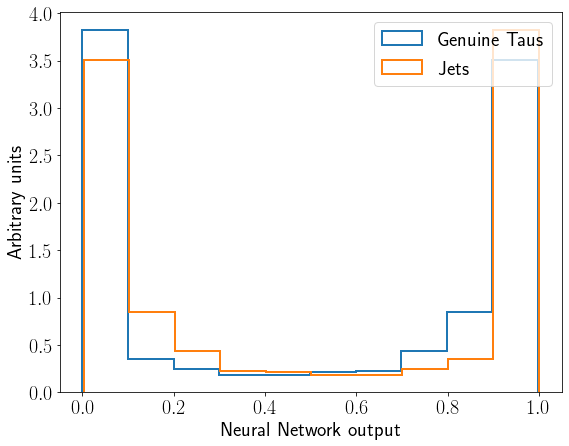

In [20]:
plt.figure(figsize=(9,7))

plt.hist(genuineTau_decisions, label='Genuine Taus', 
        histtype='step',
         density=True,
        linewidth=lw)
plt.hist(fakeTau_decisions, label='Jets', 
        histtype='step', 
         density=True,
         linewidth=lw)
plt.xlabel('Neural Network output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend
plt.show()

In [19]:
print(genuineTau_decisions[:100])
print(fakeTau_decisions[:100])

[2.42516585e-03 8.75560822e-12 3.32251966e-01 9.53463137e-01
 8.97779584e-01 7.65111923e-01 9.72640701e-05 9.66870129e-01
 2.11539344e-07 5.44210136e-01 3.75901982e-02 6.37802854e-02
 9.75991964e-01 8.31219316e-01 5.68319969e-02 6.48934007e-01
 9.61853921e-01 4.30174470e-01 1.73422726e-04 2.38187127e-02
 8.93409815e-05 9.45772648e-01 9.51306760e-01 2.55594001e-04
 9.85802531e-01 5.59815407e-01 4.06437188e-01 7.07035720e-01
 3.25798709e-03 5.11422396e-01 8.25230218e-03 2.61344248e-04
 8.36662829e-01 5.73573470e-01 5.69544907e-04 4.07611672e-03
 3.56881287e-07 8.91194582e-01 9.09437388e-02 9.49852049e-01
 9.76423800e-01 9.81101274e-01 9.02959168e-01 2.96282640e-04
 1.13855004e-01 2.82928437e-01 1.25544995e-01 1.90395355e-01
 7.18322158e-01 6.98420033e-02 2.34909892e-09 1.98309356e-03
 1.88256230e-03 9.64416981e-01 8.90508294e-01 9.63820934e-01
 1.92888803e-03 7.27263478e-06 8.97679552e-02 8.61487910e-03
 9.67218220e-01 9.00568187e-01 2.39377492e-03 1.92142669e-02
 8.96636784e-01 1.462181